In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import PIL.ImageOps    

### Boilerpalte

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# # First, look at everything.
# from subprocess import check_output
# print(check_output(["ls", "./data/combined_dataset/combined"]).decode("utf8"))

In [4]:
class Config():
    training_dir = "./data/combined_dataset/combined"
    testing_dir = "./data/combined_dataset/combined"
    training_csv="./data/combined_dataset/train_data.csv"
    testing_csv="./data/combined_dataset/test_data.csv"

    # training_dir = "./sign_data/sign_data/train"
    # testing_dir = "./sign_data/sign_data/test"
    # training_csv="./sign_data/sign_data/train_data.csv"
    # testing_csv="./sign_data/sign_data/test_data.csv"

    
    train_batch_size = 48
    # train_batch_size = 24
    train_number_epochs = 20

In [5]:
training_dir="./data/combined_dataset/combined"
training_csv="./data/combined_dataset/train_data.csv"
testing_csv="./data/combined_dataset/test_data.csv"
testing_dir="./data/combined_dataset/combined"

# training_dir="./sign_data/sign_data/train"
# training_csv="./sign_data/sign_data/train_data.csv"
# testing_csv="./sign_data/sign_data/test_data.csv"
# testing_dir="./sign_data/sign_data/test"

In [6]:
# RESCALE_SIZE = 225
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [7]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform


    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        # Loading the image
        # img0 = Image.open(image1_path).convert('L').convert('RGB')
        # img1 = Image.open(image2_path).convert('L').convert('RGB')
        
        # Loading the image
        img0 = Image.open(image1_path).convert('L')
        img1 = Image.open(image2_path).convert('L')
        
        # img0 = ImageEnhance.Contrast(img0).enhance(1.1)
        # img1 = ImageEnhance.Contrast(img1).enhance(1.1)

        img0 = PIL.ImageOps.invert(img0)
        img1 = PIL.ImageOps.invert(img1)

        # img0 = 255 - img0
        # img1 = 255 - img1

        img0 = img0.convert('RGB')
        img1 = img1.convert('RGB')
        

        # print(image1_path, image2_path)
        img0.load()
        img1.load()

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [8]:
transform = transforms.Compose([
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
              # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
      

              # transforms.RandomRotation(degrees = 10, fill=255),
            #   transforms.RandomRotation(degrees = 20),
              transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              transforms.RandomRotation(degrees = 10, fill=0),
            # transforms.RandomAffine(degrees=(-10, 10), translate=None, scale=None, shear=(-10,10), resample=False, fillcolor=(255,255,255)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.95, 1.05)),
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.9, 1.4)),
              transforms.ToTensor(),
              # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [9]:
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transform)

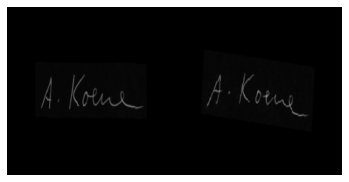

[[0.]]


In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### ResNet Siamese

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=True)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
        self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 16),
                # nn.Linear(num_ftrs, 512),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # nn.Linear(512, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # # nn.Linear(128,16)
                # nn.Linear(128,2)
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [12]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer3.parameters():
      param.requires_grad = True
    
    for param in model.layer4.parameters():
      param.requires_grad = True

    for param in model.avgpool.parameters():
      param.requires_grad = True

    for param in model.fc.parameters():
      param.requires_grad = True

In [13]:
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
        
#         self.resnet = models.inception_v3(pretrained=False)
#         set_parameter_requires_grad(self.resnet)
#         # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
#         # self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
#         num_ftrs = self.resnet.fc.in_features
#         self.resnet.fc = nn.Sequential(
#                 nn.Linear(num_ftrs, 16),
#                 # nn.Linear(num_ftrs, 512),
#                 # nn.ReLU(inplace=True),
#                 # nn.Dropout2d(p=0.5),
#                 # nn.Linear(512, 128),
#                 # nn.ReLU(inplace=True),
#                 # nn.Dropout2d(p=0.5),
#                 # # nn.Linear(128,16)
#                 # nn.Linear(128,2)
#             )
        
#     def forward_once(self, x):
#         output = self.resnet(x)
#         return output

#     def forward(self, input1, input2):
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
#         return output1, output2


In [14]:
# def set_parameter_requires_grad(model):
#     for param in model.parameters():
#         param.requires_grad = True

#     # for param in model.layer3.parameters():
#     #   param.requires_grad = True
    
#     # for param in model.layer4.parameters():
#     #   param.requires_grad = True

#     # for param in model.avgpool.parameters():
#     #   param.requires_grad = True

#     # for param in model.fc.parameters():
#     #   param.requires_grad = True

In [15]:
net = SiameseNetwork().cuda()
train_dataset = SiameseNetworkDataset(training_csv=Config.training_csv, training_dir=Config.training_dir, transform=transform)

In [16]:
print(net)

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### Loss

In [17]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2) + 
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
                )

        return loss_contrastive

### Train

In [18]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [19]:
# def train():
#     counter = []
#     loss_history = [] 
#     iteration_number= 0
    
#     for epoch in range(0,Config.train_number_epochs):
#         for i, data in enumerate(train_dataloader,0):
#             img0, img1 , label = data
#             img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
#             optimizer.zero_grad()
#             output1, output2 = net(img0,img1)
#             loss_contrastive = criterion(output1,output2,label)
#             loss_contrastive.backward()
#             optimizer.step()
#             if i %50 == 0 :
#                 print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
#                 iteration_number +=10
#                 counter.append(iteration_number)
#                 loss_history.append(loss_contrastive.item())
#     return net

In [20]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for i, data in enumerate(train_loader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()


        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
              
    train_loss = running_loss / processed_data

    return train_loss

In [21]:
def train(train_files, net, epochs, batch_size):
    train_dataloader = DataLoader(train_files,
                        shuffle=True,
                        num_workers=4,
                        batch_size=batch_size)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optim.AdamW(net.parameters(), lr=0.002)
        scheduler = StepLR(opt, step_size=5, gamma=0.5)
        criterion = ContrastiveLoss()

        for epoch in range(epochs):
            train_loss = fit_epoch(net, train_dataloader, criterion, opt)
            print("loss", train_loss)
            
            scheduler.step()
            history.append((train_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss))
            
    return history

In [22]:
history = train(train_dataset, net=net, epochs=Config.train_number_epochs, batch_size=Config.train_batch_size)

epoch:   5%|▌         | 1/20 [13:58<4:25:39, 838.94s/it]loss 1.0477049964420493

Epoch 001 train_loss: 1.0477
epoch:  10%|█         | 2/20 [28:40<4:15:30, 851.71s/it]loss 0.9913899115998179

Epoch 002 train_loss: 0.9914
epoch:  15%|█▌        | 3/20 [43:26<4:04:15, 862.12s/it]loss 0.9883699034591944

Epoch 003 train_loss: 0.9884
epoch:  20%|██        | 4/20 [58:13<3:51:49, 869.34s/it]loss 0.9864584532608385

Epoch 004 train_loss: 0.9865
epoch:  25%|██▌       | 5/20 [1:13:01<3:38:48, 875.22s/it]loss 0.9866170691213839

Epoch 005 train_loss: 0.9866
epoch:  30%|███       | 6/20 [1:27:54<3:25:24, 880.35s/it]loss 0.981393587413975

Epoch 006 train_loss: 0.9814
epoch:  35%|███▌      | 7/20 [1:42:49<3:11:43, 884.91s/it]loss 0.9819037289313394

Epoch 007 train_loss: 0.9819
epoch:  40%|████      | 8/20 [1:57:47<2:57:43, 888.63s/it]loss 0.9815910493601226

Epoch 008 train_loss: 0.9816
epoch:  45%|████▌     | 9/20 [2:12:33<2:42:48, 888.01s/it]loss 0.9819671681757148

Epoch 009 train_loss: 0.9820
e

In [23]:
# torch.save(net.state_dict(), "model.pt")
# print("Model Saved Successfully")

In [24]:
# # Load the saved model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [25]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 10),
            #   transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.7, 1.0)),
              transforms.ToTensor(),
              # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [26]:
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,                                     transform=transform)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [27]:
from tqdm import tqdm

In [39]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
threshhold = torch.FloatTensor([0.1]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1 , label = data
    output1,output2 = net(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        targets.append(0)
    else:
        targets.append(1)
    
    if eucledian_distance <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

100%|██████████| 12672/12672 [02:52<00:00, 73.38it/s]


In [40]:
from sklearn.metrics import f1_score

In [41]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.5691287878787878

In [42]:
f1_score(n_targets, n_predictions, average='weighted')

0.5642856768609288

In [43]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.7950397753860552

In [44]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

0.7891414141414141

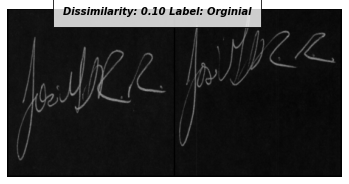

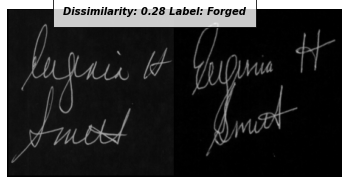

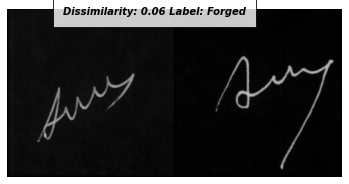

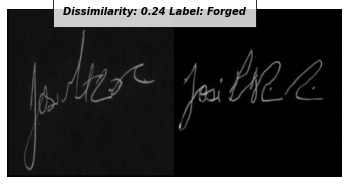

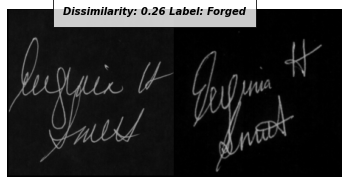

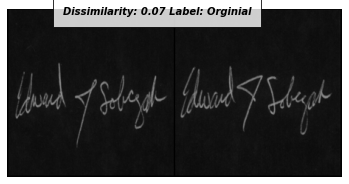

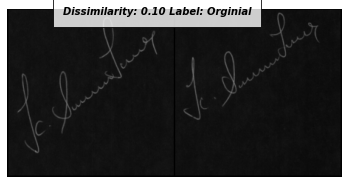

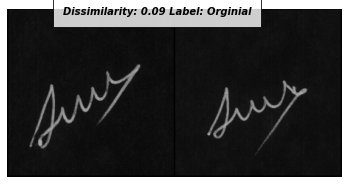

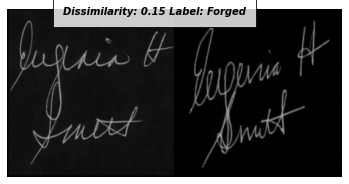

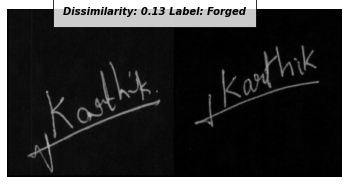

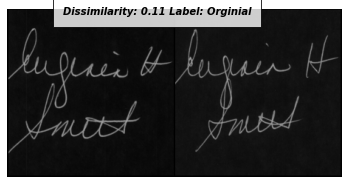

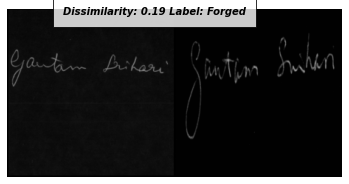

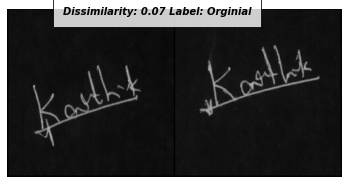

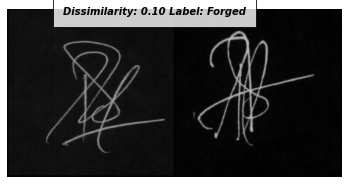

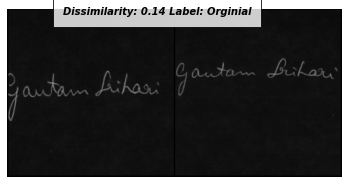

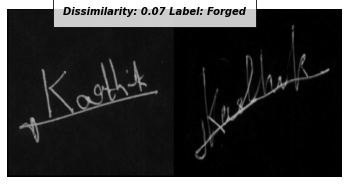

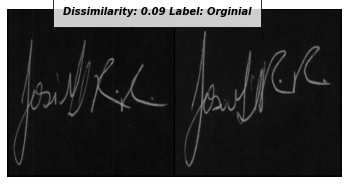

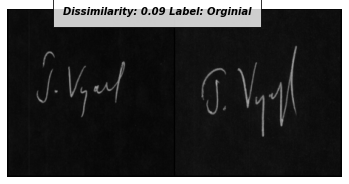

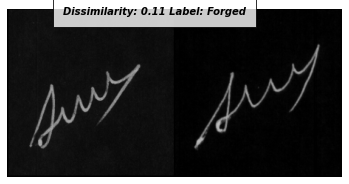

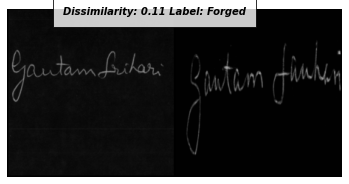

In [46]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = net(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [ ]:
# Gridsearch границы forged/original
# tiplet loss
# accuracy
# concat datasets

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Public kernel: https://www.kaggle.com/robinreni/signature-classification-using-siamese-pytorch 